In [23]:
import numpy as np
import os
import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt

import netCDF4 as nc
import matplotlib as mpl
import sys

extra_path = '/p/project/cjibg36/kaandorp2/Git/SLOTH' 
if extra_path not in sys.path:
    sys.path.append(extra_path)

import sloth.IO

In [3]:
folder_static = '/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static'
folder_baseline = '/p/project/cjibg36/kaandorp2/TSMP_setups/setup_DA_clean_tsmp_cordex_222x216' # folder from which to copy namelists etc.

In [4]:
# NL / NW Germany
ix_start =185
iy_start =215
nx = 40
ny = 40



folder_out = '/p/project/cjibg36/kaandorp2/TSMP_setups/setup_tsmp_11km_ix%i_iy%i_%ix%i/' % (ix_start,iy_start,nx,ny)
if not os.path.exists(folder_out):
    print('Creating folder for setup: %s' % (folder_out) )
    os.mkdir(folder_out)

    os.mkdir(os.path.join(folder_out,'input_clm'))
    os.mkdir(os.path.join(folder_out,'input_pf'))
    os.mkdir(os.path.join(folder_out,'input_oas'))
    os.mkdir(os.path.join(folder_out,'namelists'))
    
ind_x = xr.DataArray(np.arange(ix_start,ix_start+nx), dims=["lsmlon"])
ind_y = xr.DataArray(np.arange(iy_start,iy_start+ny), dims=["lsmlat"])

In [4]:
# ls /p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/parflow

# CLM

In [5]:
# griddata = xr.load_dataset('/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static.resource/01_Grids/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432_gridfile.nc')
files_clm = sorted(glob(os.path.join(folder_static,'clm/*444x432.nc')))
files_clm

['/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/clm/fracdata_CLM_EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432.nc',
 '/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/clm/griddata_CLM_EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432.nc',
 '/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/clm/surfdata_CLM_EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432.nc',
 '/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/clm/topodata_CLM_EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432.nc']

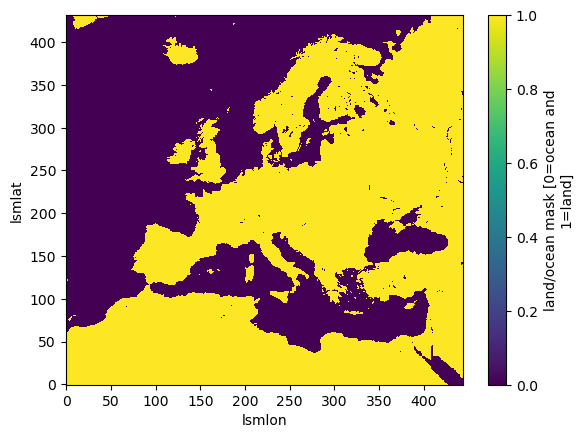

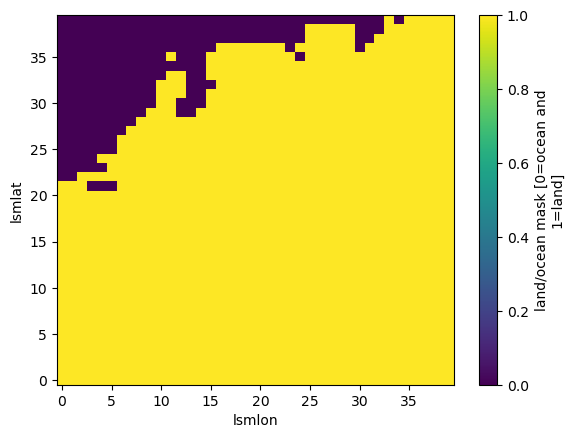

In [7]:
data = xr.open_dataset(files_clm[1])
%matplotlib inline
plt.figure()
data['LANDMASK'].plot.pcolormesh()

plt.figure()
data['LANDMASK'][ind_y,ind_x].plot.pcolormesh()
plt.savefig(os.path.join(folder_out,'domain.png'))

In [8]:
edge_n = np.nan
edge_e = np.nan
edge_s = np.nan
edge_w = np.nan
for i1,file_ in enumerate(files_clm):

    data = xr.open_dataset(file_)

    data_extract = xr.Dataset()


    for var_ in data.variables:
        # print(var_)
        if len( data[var_].dims ) == 4:
            data_extract[var_] = data[var_][:,:,ind_y,ind_x]
        elif len( data[var_].dims ) == 3:
            data_extract[var_] = data[var_][:,ind_y,ind_x]
        elif len( data[var_].dims ) == 2:
            # print(data[var_])
            data_extract[var_] = data[var_][ind_y,ind_x]

        else:
            if 'lsmlat' in data[var_].dims:
                data_extract[var_] = data[var_][ind_y]
            elif 'lsmlon' in data[var_].dims:
                data_extract[var_] = data[var_][ind_x]
            else:
                data_extract[var_] = data[var_]

    if i1 == 0:
        # topodata does not contain edge data, so save this
        edge_n = np.max(data['LATN'][ind_y,ind_x])
        edge_e = np.max(data['LONE'][ind_y,ind_x])
        edge_s = np.min(data['LATS'][ind_y,ind_x])
        edge_w = np.min(data['LONW'][ind_y,ind_x])
                        
    assert(~np.isnan(edge_n))               
    data_extract['NUMLON'].values = np.ones(len(data_extract['NUMLON']))*nx
    data_extract['EDGEN'].values = np.array([edge_n])
    data_extract['EDGEE'].values = np.array([edge_e])
    data_extract['EDGES'].values = np.array([edge_s])
    data_extract['EDGEW'].values = np.array([edge_w])

    data_extract.attrs['author'] = 'm.kaandorp@fz-juelich.de'

    data_extract.to_netcdf(os.path.join(folder_out,'input_clm',os.path.basename(file_).replace('444x432','%ix%i'%(nx,ny)) ))
    # print(data)
    # print(data_extract)


In [10]:
data

<xarray.Dataset>
Dimensions:             (lsmlat: 432, lsmlon: 444, ncl6: 1, nlevsoi: 10,
                         lsmpft: 17, time: 12, ncl5: 12, ncl7: 1, ncl8: 1,
                         ncl9: 1, ncl10: 1)
Coordinates:
    time                (ncl5) int32 ...
Dimensions without coordinates: lsmlat, lsmlon, ncl6, nlevsoi, lsmpft, ncl5,
                                ncl7, ncl8, ncl9, ncl10
Data variables: (12/29)
    NUMLON              (lsmlat) float64 ...
    LONGXY              (lsmlat, lsmlon) float64 ...
    LATIXY              (lsmlat, lsmlon) float64 ...
    LONE                (lsmlat, lsmlon) float64 ...
    LATN                (lsmlat, lsmlon) float64 ...
    LONW                (lsmlat, lsmlon) float64 ...
    ...                  ...
    MONTHLY_HEIGHT_TOP  (time, lsmpft, lsmlat, lsmlon) float64 ...
    MONTHLY_HEIGHT_BOT  (time, lsmpft, lsmlat, lsmlon) float64 ...
    EDGEN               (ncl7) float64 ...
    EDGEE               (ncl8) float64 ...
    EDGES               (ncl9) float64 ...
    EDGEW               (ncl10) float64 ...
Attributes:
    author:         Niklas WAGNER, Klaus GOERGEN, Alexandre BELLEFLAMME
    contact:        n.wagner@fz-juelich.de, k.goergen@fz-juelich.de, a.bellef...
    institution:    FZJ/IBG-3
    history:        Created 30/05/23
    source:         
    creation_date:  2023-05-30T06:43Z

In [170]:
data_extract

<xarray.Dataset>
Dimensions:   (lsmlat: 40, lsmlon: 40, ncl7: 1, ncl8: 1, ncl9: 1, ncl10: 1)
Dimensions without coordinates: lsmlat, lsmlon, ncl7, ncl8, ncl9, ncl10
Data variables: (12/13)
    NUMLON    (lsmlat) float64 40.0 40.0 40.0 40.0 40.0 ... 40.0 40.0 40.0 40.0
    LONGXY    (lsmlat, lsmlon) float64 ...
    LATIXY    (lsmlat, lsmlon) float64 ...
    LONE      (lsmlat, lsmlon) float64 4.078 4.243 4.408 ... 9.503 9.689 9.874
    LATN      (lsmlat, lsmlon) float64 ...
    LONW      (lsmlat, lsmlon) float64 ...
    ...        ...
    AREA      (lsmlat, lsmlon) float64 ...
    LANDMASK  (lsmlat, lsmlon) float64 ...
    EDGEN     (ncl7) float64 54.0
    EDGEE     (ncl8) float64 10.6
    EDGES     (ncl9) float64 49.01
    EDGEW     (ncl10) float64 2.562
Attributes:
    author:   m.kaandorp@fz-juelich.de

In [9]:
for file_ in ['lnd.clmoas.rpointer','pft-physiology.c070321.readme','pft-physiology.c110504']:
    shutil.copy(os.path.join(folder_baseline,'input_clm',file_), os.path.join(folder_out,'input_clm') )

# ParFlow

### 1) create parflow solidfile

In [6]:
import netCDF4 as nc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

extra_path = '/p/project/cjibg36/kaandorp2/Git/SLOTH' 
if extra_path not in sys.path:
    sys.path.append(extra_path)

import sloth.IO 


# import sloth.IO
folder_pf = os.path.join(folder_out,'input_pf')

LLSMFileName = '/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/land-lake-sea-mask/EUR-11_TSMP_FZJ-IBG3_444x432_LAND-LAKE-SEA-MASK.nc'
LLSMVarName  = 'LLSM'

LLSM_orig = xr.load_dataset(LLSMFileName,decode_times=False)['LLSM']

ind_x = xr.DataArray(np.arange(ix_start,ix_start+nx), dims=["rlon"])
ind_y = xr.DataArray(np.arange(iy_start,iy_start+ny), dims=["rlat"])

LLSM = LLSM_orig[0,ind_y,ind_x]

ny, nx = LLSM.shape
nz = 15
dy = dx = 12500.0
dz = 2.0

# write PFBMask:
# 0 where LLSM is land or leak
# 1 where LLSM is ocean
PFBMask = np.where((LLSM<1), 0, 1)
print(f'PFBMask.shape: {PFBMask.shape}')


# save as .pfb
PFBMaskFileName = os.path.join(folder_pf,'PfbMask4SolidFile.pfb')
sloth.IO.create_pfb(PFBMaskFileName, PFBMask[np.newaxis,...], delta=(dz,dy,dx))


PFBMask.shape: (40, 40)


In [20]:
xr.load_dataset(LLSMFileName,decode_times=False)

<xarray.Dataset>
Dimensions:       (rlon: 444, rlat: 432, time: 1)
Coordinates:
  * rlon          (rlon) float32 -29.48 -29.36 -29.25 ... 19.03 19.15 19.25
  * rlat          (rlat) float32 -24.48 -24.36 -24.25 ... 22.72 22.83 22.93
  * time          (time) int32 738670
    lon           (rlat, rlon) float32 -10.58 -10.48 -10.38 ... 68.53 68.73
    lat           (rlat, rlon) float32 20.58 20.62 20.66 ... 67.03 66.97 66.9
Data variables:
    LLSM          (time, rlat, rlon) float32 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    rotated_pole  |S1 b''
Attributes:
    author:       Niklas WAGNER, Klaus GOERGEN, Alexandre BELLEFLAMME
    contact:      n.wagner@fz-juelich.de, k.goergen@fz-juelich.de, a.bellefla...
    institution:  FZJ/IBG-3
    history:      Created 30/05/23
    source:       
    description:  Land=2 Lake=1 Sea=0 Mask

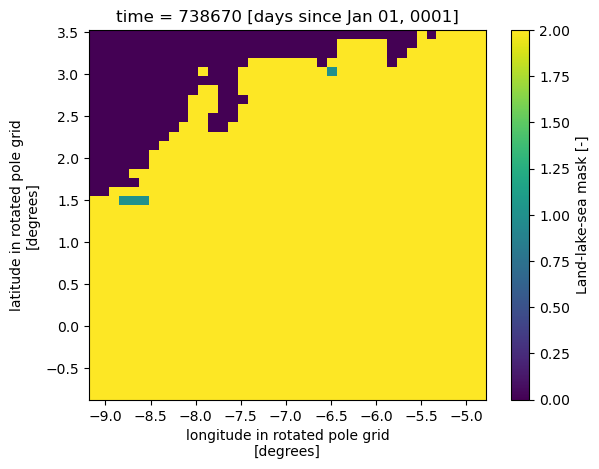

In [11]:
plt.figure()
LLSM.plot.pcolormesh()

In [7]:
# Run the ParFlow pfmask-to-pfsol script
dir_env = '/p/project/cjibg36/kaandorp2/TSMP_patched/bldsva/machines/JUWELS/'
dir_pf_bin = '/p/project/cjibg36/kaandorp2/TSMP_patched/bin/JUWELS_3.1.0MCT_clm-pfl/bin'
dir_curr = os.getcwd()

os.chdir(dir_pf_bin)

str_cmd = '''
source %s/loadenvs.Intel
./pfmask-to-pfsol --z-top 30 --z-bottom 0 --mask %s/PfbMask4SolidFile.pfb --pfsol %s/PfbMask4SolidFile_%ix%i.pfsol > %s/PfbMask4SolidFile.log
''' % (dir_env,
       folder_pf,folder_pf,nx,ny,folder_pf)

os.system(str_cmd)
os.chdir(dir_curr)


  Preparing the environment for use of requested stage ( 2020 ).


Currently Loaded Modules:
  1) Stages/2020                         (S)
  2) GCCcore/.9.3.0                      (H)
  3) zlib/.1.2.11                        (H)
  4) binutils/.2.34                      (H)
  5) Intel/2020.2.254-GCC-9.3.0
  6) numactl/2.0.13
  7) nvidia-driver/.default              (H)
  8) CUDA/11.0                           (g)
  9) UCX/1.9.0
 10) pscom/.5.4-default                  (H)
 11) XZ/.5.2.5                           (H)
 12) libxml2/.2.9.10                     (H)
 13) mpi-settings/UCX-plain
 14) ParaStationMPI/5.4.7-1              (g)
 15) imkl/2020.2.254
 16) Hypre/2.20.0
 17) Silo/4.10.2
 18) Tcl/8.6.10
 19) GMP/6.2.0
 20) nettle/.3.6                         (H)
 21) bzip2/.1.0.8                        (H)
 22) expat/.2.2.9                        (H)
 23) libpng/.1.6.37                      (H)
 24) freetype/.2.10.1                    (H)
 25) gperf/.3.1                          (H)
 26)

### 2) cut-out of .sa files (slopes etc.)

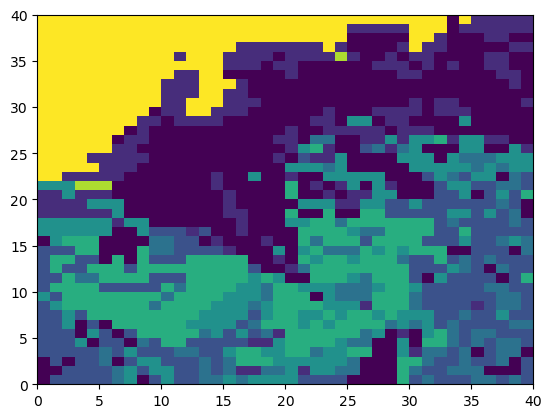

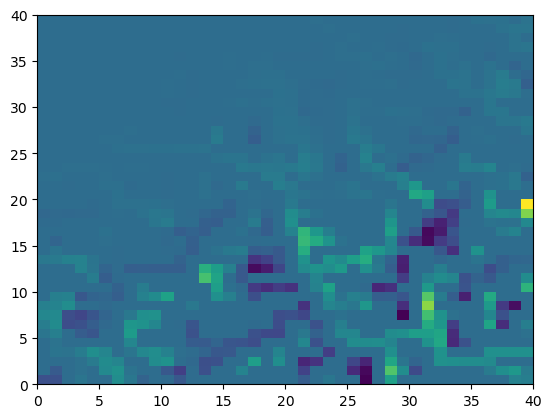

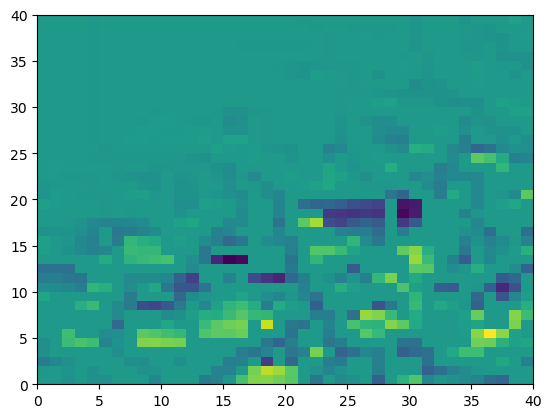

In [13]:

files_sa = ['/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/parflow/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa',
            '/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/parflow/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432_XSLOPE_TPS_HydroRIVER_sea_streams_corr.sa',
            '/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/parflow/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432_YSLOPE_TPS_HydroRIVER_sea_streams_corr.sa']

filenames_out = ['EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa'.replace('444x432','%ix%i'%(nx,ny)),
                 'slopex.sa',
                 'slopey.sa']

for file_,file_out in zip(files_sa,filenames_out):
    data = sloth.IO.readSa(file_)
    
    data_extract = data[np.ix_(np.arange(data.shape[0]),ind_y.values,ind_x.values)]
    
    plt.figure()
    plt.pcolormesh(data_extract[0,:,:])
    
    sloth.IO.writeSa(os.path.join(folder_pf,file_out), data_extract)

In [14]:
data_extract.shape

(1, 40, 40)

In [15]:
for file_ in glob(os.path.join(folder_baseline,'input_pf','ascii*')):
    shutil.copy(file_, os.path.join(folder_out,'input_pf') )

# OASIS

In [16]:
file_ = '/p/project/cjibg36/kaandorp2/TSMP_EUR-11/static/oasis/clmgrid.nc'
data = xr.load_dataset(file_)

ind_x = xr.DataArray(np.arange(ix_start,ix_start+nx), dims=["lon"])
ind_y = xr.DataArray(np.arange(iy_start,iy_start+ny), dims=["lat"])

data_extract = xr.Dataset()

for var_ in data.variables:
    print(var_)
    if len( data[var_].dims ) == 2:
        # print(data[var_])
        data_extract[var_] = data[var_][ind_y,ind_x]

    else:
        if 'lat' in data[var_].dims:
            data_extract[var_] = data[var_][ind_y]
        elif 'lon' in data[var_].dims:
            data_extract[var_] = data[var_][ind_x]
data_extract.attrs['author'] = 'm.kaandorp@fz-juelich.de'

data_extract.to_netcdf(os.path.join(folder_out,'input_oas',os.path.basename(file_)))


AREA
LANDMASK
LATIXY
LATN
LATS
LONE
LONGXY
LONW
lat
lon


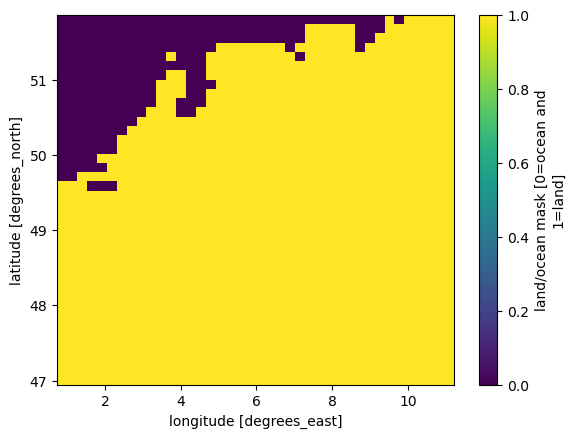

In [17]:
%matplotlib inline
plt.figure()
data_extract.LANDMASK.plot.pcolormesh()

In [18]:
dir_curr = os.getcwd()

os.chdir(os.path.join(folder_out,'input_oas'))

str_cmd = '''
module load Stages/2020  GCC/9.3.0  ParaStationMPI/5.4.7-1 CDO/1.9.8 NCO/4.9.5
cdo -P 8 gendis,clmgrid.nc clmgrid.nc rmp_gclm_to_gpfl_DISTWGT.nc 
cdo -P 8 gendis,clmgrid.nc clmgrid.nc rmp_gpfl_to_gclm_BILINEAR.nc 
''' 

os.system(str_cmd)
os.chdir(dir_curr)




  This stage is deprecated. Please consider moving to a new stage (2023
or newer)


Inactive Modules:
  1) BeautifulSoup/4.10.0
  2) BioPerl/1.7.8
  3) Boost/1.79.0
  4) Brotli/.1.0.9
  5) Cling/20230205
  6) DB/.18.1.40
  7) DB_File/.1.858
  8) DBus/.1.14.0
  9) FFmpeg/.4.4.2
 10) FriBidi/1.0.12
 11) GEOS/3.11.1
 12) GLib/.2.72.1
 13) HarfBuzz/.4.2.1
 14) ICU/.71.1
 15) IPython/8.14.0
 16) JupyterKernel-Bash/.0.9.0-2023.3.6
 17) JupyterKernel-Cling/.20230205-2023.3.6
 18) JupyterKernel-Julia/.1.8.5-2023.3.6
 19) JupyterKernel-LFortran/.0.19.0-2023.3.6
 20) JupyterKernel-Octave/.8.2.0-2023.3.6
 21) JupyterKernel-PyDeepLearning/.2023.5-2023.3.6
 22) JupyterKernel-PyEarthSystem/.2023.5-2023.3.6
 23) JupyterKernel-PyQuantum/.2023.5-2023.3.6
 24) JupyterKernel-PyVisualization/.2023.5-2023.3.6
 25) JupyterKernel-R/.4.2.1-2023.3.6
 26) JupyterKernel-Ruby/.3.0.5-2023.3.6
 27) JupyterLab/2023.3.6
 28) JupyterProxy-XpraHTML5/.0.3.5-2023.3.6
 29) LibTIFF/.4.3.0
 30) MPC/1.2.1
 31) NSPR/4.34
 32

# Misc

In [19]:
for file_ in glob(os.path.join(folder_baseline,'namelists','*')):
    shutil.copy(file_, os.path.join(folder_out,'namelists') )

# Forcing

In [20]:
years = [2018,2019]
folder_forcing = '/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM'
folder_forcing_out = folder_forcing + '_ix%i_iy%i_%ix%i' % (ix_start,iy_start,nx,ny)

if not os.path.exists(folder_forcing_out):
    print('Creating folder for setup: %s' % (folder_forcing_out) )
    os.mkdir(folder_forcing_out)
    
    
ind_lsmlon = xr.DataArray(np.arange(ix_start,ix_start+nx), dims=["lsmlon"])
ind_lsmlat = xr.DataArray(np.arange(iy_start,iy_start+ny), dims=["lsmlat"])
ind_lon = xr.DataArray(np.arange(ix_start,ix_start+nx), dims=["lon"])
ind_lat = xr.DataArray(np.arange(iy_start,iy_start+ny), dims=["lat"])

edge_n = np.nan
edge_e = np.nan
edge_s = np.nan
edge_w = np.nan

for year_ in years:
    files = sorted(glob(os.path.join(folder_forcing,'%i*'%year_)))
    
    for file_ in files:
        
        data = xr.open_dataset(file_)
        data_extract = xr.Dataset()


        for var_ in data.variables:

            if 'lsmlat' in data[var_].dims:
                if len( data[var_].dims ) == 1:
                    data_extract[var_] = data[var_][ind_lsmlat]
                elif len( data[var_].dims ) == 2:
                    data_extract[var_] = data[var_][ind_lsmlat,ind_lsmlon]
                else:
                    print('error, this shouldnt happen check this')
            
            elif 'lat' in data[var_].dims:
                if len( data[var_].dims ) == 3:
                    data_extract[var_] = data[var_][:,ind_lat,ind_lon]
                else:
                    print('error, this shouldnt happen check this')
            else:
                data_extract[var_] = data[var_]


        edge_n = np.max(data['LATN'][ind_lsmlat,ind_lsmlon])
        edge_e = np.max(data['LONE'][ind_lsmlat,ind_lsmlon])
        edge_s = np.min(data['LATS'][ind_lsmlat,ind_lsmlon])
        edge_w = np.min(data['LONW'][ind_lsmlat,ind_lsmlon])

        assert(~np.isnan(edge_n))               
        data_extract['NUMLON'].values = np.ones(len(data_extract['NUMLON']))*nx
        data_extract['EDGEN'].values = np.array([edge_n])
        data_extract['EDGEE'].values = np.array([edge_e])
        data_extract['EDGES'].values = np.array([edge_s])
        data_extract['EDGEW'].values = np.array([edge_w])

        data_extract.attrs['author'] = 'm.kaandorp@fz-juelich.de'

        data_extract.to_netcdf(os.path.join(folder_forcing_out,os.path.basename(file_) ))    

        print(os.path.join(folder_forcing_out,os.path.basename(file_) ) )


/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-01.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-02.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-03.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-04.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-05.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-06.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-07.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-08.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-09.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-10.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-11.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix185_iy215_40x40/2018-12.nc
/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-11_CLM_ix

# DA files

In [19]:
file_corner='/p/project/cjibg36/kaandorp2/TSMP_setups/static/EUR-11_444x432_corners_curvi_Tair.nc'

ind_x = xr.DataArray(np.arange(ix_start,ix_start+nx+1), dims=["x"])
ind_y = xr.DataArray(np.arange(iy_start,iy_start+ny+1), dims=["y"])

data = xr.load_dataset(file_corner)

data_extract = xr.Dataset()

data_extract['lon'] = (['y','x'],data['lon'][ind_y,ind_x].values)
data_extract['lat'] = (['y','x'],data['lat'][ind_y,ind_x].values)

data_extract.attrs['author'] = 'm.kaandorp@fz-juelich.de'

data_extract.to_netcdf(os.path.join(folder_out,'input_clm','EUR-11_%ix%i_corners_curvi.nc'%(nx,ny) ))

In [20]:
data_extract

<xarray.Dataset>
Dimensions:  (y: 41, x: 41)
Dimensions without coordinates: y, x
Data variables:
    lon      (y, x) float32 3.929 4.094 4.258 4.423 ... 9.307 9.493 9.678 9.864
    lat      (y, x) float32 49.0 49.02 49.04 49.06 ... 53.97 53.98 53.99 54.01
Attributes:
    author:   m.kaandorp@fz-juelich.de

In [24]:
file_lsm='/p/project/cjibg36/kaandorp2/TSMP_setups/static/EUR-11_TSMP_FZJ-IBG3_444x432_LAND-LAKE-SEA-MASK.nc'
folder_pf = os.path.join(folder_out,'input_pf')

ind_x = xr.DataArray(np.arange(ix_start,ix_start+nx), dims=["rlon"])
ind_y = xr.DataArray(np.arange(iy_start,iy_start+ny), dims=["rlat"])

data = xr.load_dataset(file_lsm,decode_times=False )

data_extract = xr.Dataset()

data_extract['rlat'] = data['rlat'][ind_y]
data_extract['rlon'] = data['rlon'][ind_x]
data_extract['time'] = data['time']
data_extract['lon'] = (['rlat','rlon'],data['lon'][ind_y,ind_x].values)
data_extract['lat'] = (['rlat','rlon'],data['lat'][ind_y,ind_x].values)
data_extract['LLSM'] = (['time','rlat','rlon'],data['LLSM'][:,ind_y,ind_x].values)

data_extract.attrs['author'] = 'm.kaandorp@fz-juelich.de'

        
    
    
#check rivers in indicator file
file_ = os.path.join(folder_pf,'EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa'.replace('444x432','%ix%i'%(nx,ny)))
data = sloth.IO.readSa(file_)
  
mask_rivers = data[-1,:,:]==13
data_extract['mask_rivers'] = (['rlat','rlon'], mask_rivers.astype(int))


data_extract.to_netcdf(os.path.join(folder_out,'input_clm',os.path.basename(file_lsm).replace('444x432','%ix%i'%(nx,ny)) ))


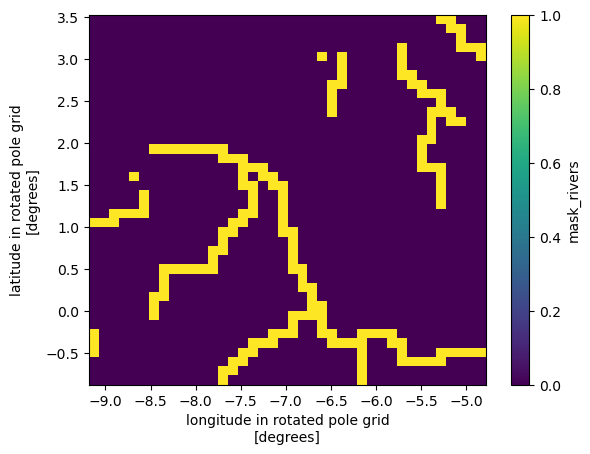

In [110]:
plt.figure()
data_extract.mask_rivers.plot.pcolormesh()

In [32]:
file_centre = os.path.join(folder_out,'input_clm',os.path.basename(file_lsm).replace('444x432','%ix%i'%(nx,ny)) )
file_corner = os.path.join(folder_out,'input_clm','EUR-11_%ix%i_corners_curvi.nc'%(nx,ny) )
ignore_rivers = True

grid_centre = xr.open_dataset(file_centre, decode_times=False)
grid_corner = xr.open_dataset(file_corner)

lon_edges = np.concatenate((grid_corner.lon.values[:,-1],grid_corner.lon.values[:,0],grid_corner.lon.values[0,:],grid_corner.lon.values[-1,:]))
lat_edges = np.concatenate((grid_corner.lat.values[:,-1],grid_corner.lat.values[:,0],grid_corner.lat.values[0,:],grid_corner.lat.values[-1,:]))
lsm_edges = np.zeros(lat_edges.shape)

grid_TSMP = xr.Dataset(data_vars=dict(lon_centre=(['x','y'], grid_centre.lon.values),
                                      lat_centre=(['x','y'], grid_centre.lat.values),
                                      lon_corner=(['xc','yc'], grid_corner.lon.values),
                                      lat_corner=(['xc','yc'], grid_corner.lat.values),
                                      lsm=(['x','y'], grid_centre.LLSM[0].values),
                                      lon_edges=(['ne'], lon_edges),
                                      lat_edges=(['ne'], lat_edges),
                                      lsm_edges=(['ne'], lsm_edges)))


if ignore_rivers:
    # in the land-sea mask, set rivers to a value of 3, in which case they are ignored later in the interpolation process
    grid_TSMP['lsm'] = grid_TSMP['lsm'].where((grid_centre.mask_rivers.values==0),3)

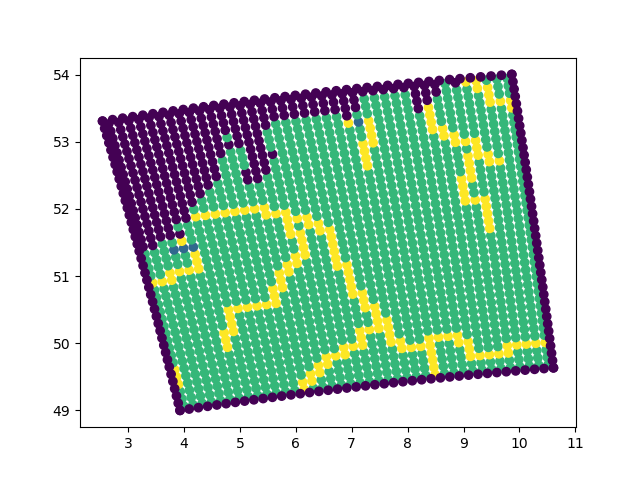

In [36]:
grid_TSMP

plt.figure()
plt.scatter(grid_TSMP.lon_centre.values.ravel(),grid_TSMP.lat_centre.values.ravel(),c=grid_TSMP.lsm.values.ravel())
plt.scatter(grid_TSMP.lon_edges.values.ravel(),grid_TSMP.lat_edges.values.ravel(),c=grid_TSMP.lsm_edges.values.ravel())


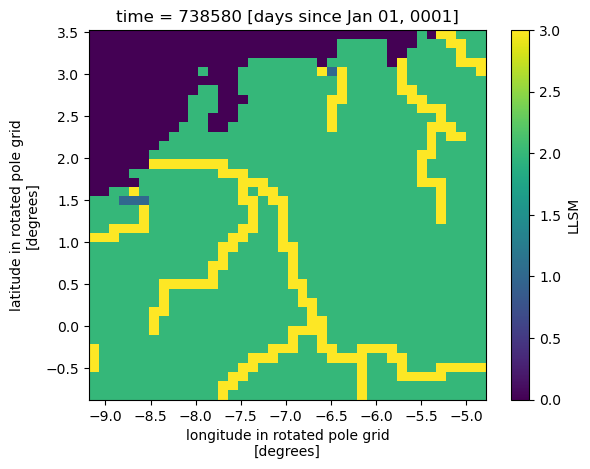

In [112]:
plt.figure()
data_extract.LLSM[0].plot.pcolormesh()

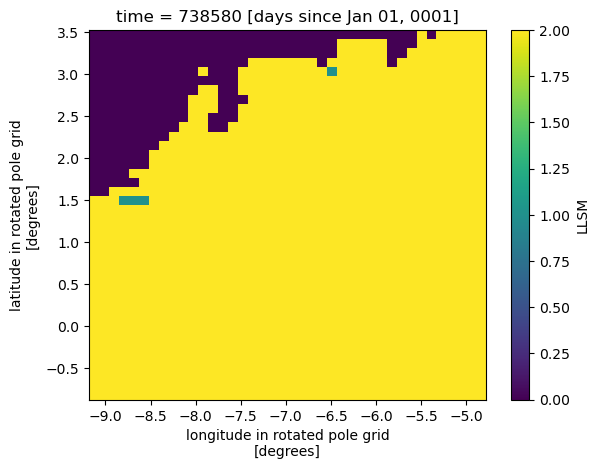

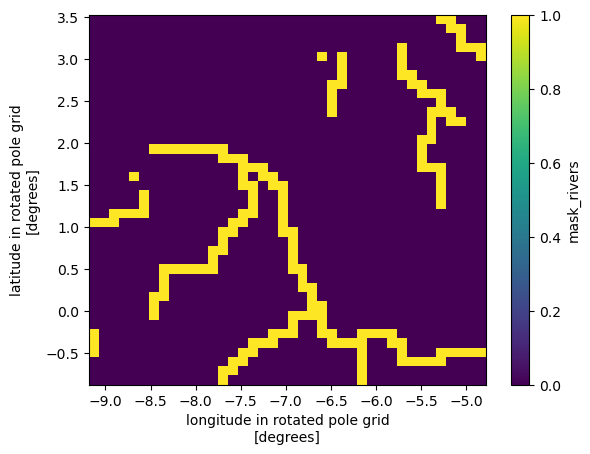

In [75]:
%matplotlib inline
plt.figure()
data_extract.LLSM[0].plot.pcolormesh()

plt.figure()
data_extract.mask_rivers.plot.pcolormesh()


# Restart data

<xarray.Dataset>
Dimensions:                (gridcell: 26180, landunit: 26180, column: 26180,
                            pft: 26180, levsno: 5, numrad: 2, levtot: 15,
                            levlak: 10)
Dimensions without coordinates: gridcell, landunit, column, pft, levsno,
                                numrad, levtot, levlak
Data variables: (12/89)
    timemgr_rst_type       int32 1
    timemgr_rst_step_sec   int32 900
    timemgr_rst_start_ymd  int32 20190222
    timemgr_rst_start_tod  int32 43200
    timemgr_rst_ref_ymd    int32 20190222
    timemgr_rst_ref_tod    int32 43200
    ...                     ...
    ftii                   (pft, numrad) float64 1.0 1.0 1.0 ... 0.4084 1.0 1.0
    T_VEG                  (pft) float64 308.5 308.4 308.3 ... 285.3 285.5 278.2
    T_REF2M                (pft) float64 309.4 309.3 309.2 ... 279.1 279.6 279.0
    H2OCAN                 (pft) float64 0.0 0.0 0.0 ... 1.084e-19 5.421e-20 0.0
    TREFAV_VALUE           (pft) float64 309.2 309.0 308.9 ... 279.1 279.6 279.0
    TREFAV_PERIOD          int32 4
Attributes:
    conventions:      CF-1.0
    history:          created on 09/05/23 04:26:05
    logname:          kaandorp2
    host:             
    source:           Community Land Model: CLM3
    version:          $HeadURL: https://svn-ccsm-models.cgd.ucar.edu/clm2/bra...
    revision_id:      $Id: restFileMod.F90 4183 2007-04-30 20:20:27Z erik $
    case_title:       clm
    case_id:          clm
    surface_dataset:  /p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/...

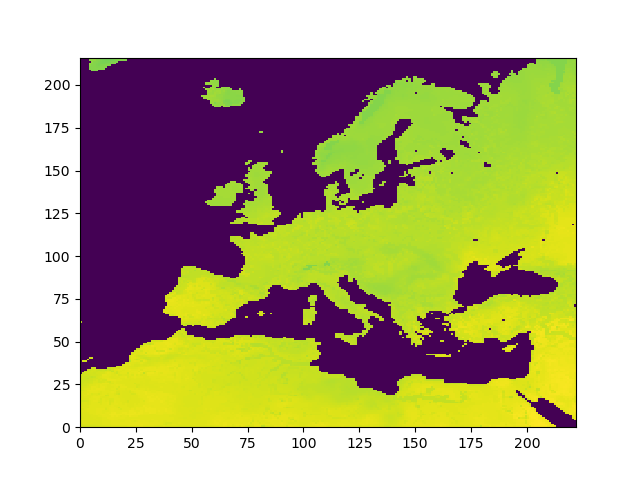

In [48]:
## Working with restart data

data = xr.load_dataset('/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_222x216_v2/20180501-20190601/i001/R000/run_20190222-20190601/clm.clm2.r.2019-06-01-43200.nc')

res = np.zeros([222,216])

np.add.at(res,(data.grid1d_ixy.values-1,data.grid1d_jxy.values-1),data.T_GRND.values)

%matplotlib widget
plt.figure()
plt.pcolormesh(res.T)


In [5]:
data = xr.load_dataset('/p/scratch/cslts/hartick1/eu11_clm5_juwels/restart_16_replaced/EU11.clm2.r.2017-06-30-00000.nc')
data

/p/software/juwels/stages/2023/software/xarray/2022.9.0-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'timemgr_rst_nstep_rad_prev' has multiple fill values {-9999, -999999999}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/p/software/juwels/stages/2023/software/xarray/2022.9.0-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'timemgr_rst_type' has multiple fill values {-9999, -999999999}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/p/software/juwels/stages/2023/software/xarray/2022.9.0-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'timemgr_rst_step_sec' has multiple fill values {-9999, -999999999}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/p/software/juwels/stages/2023/software/xarray/2022.9.0-gcccoremkl-11.3.0-2022.1.0/lib/py

<xarray.Dataset>
Dimensions:                               (gridcell: 191808, landunit: 197799,
                                           column: 251718, levgrnd: 25,
                                           pft: 251718, glc_nec1: 11,
                                           levsno: 12, vegwcs: 4, levlak: 10,
                                           levcan: 1, numrad: 2, levtot: 37,
                                           levsno1: 13, ntapes: 1)
Dimensions without coordinates: gridcell, landunit, column, levgrnd, pft,
                                glc_nec1, levsno, vegwcs, levlak, levcan,
                                numrad, levtot, levsno1, ntapes
Data variables: (12/475)
    timemgr_rst_nstep_rad_prev            float64 8.64e+03
    timemgr_rst_type                      float64 1.0
    timemgr_rst_step_sec                  float64 1.8e+03
    timemgr_rst_start_ymd                 float64 2.017e+07
    timemgr_rst_start_tod                 float64 0.0
    timemgr_rst_ref_ymd                   float64 2.017e+07
    ...                                    ...
    soil3c_vr                             (column, levgrnd) float64 200.2 ......
    col_ctrunc_vr                         (column, levgrnd) float64 0.0 ... 0.0
    spinup_state                          float64 0.0
    history_tape_in_use                   (ntapes) int32 1
    locfnh                                (ntapes) |S199 b'./EU11.clm2.h0.201...
    locfnhr                               (ntapes) |S199 b'./EU11.clm2.rh0.20...
Attributes: (12/117)
    Conventions:                               CF-1.0
    history:                                   created on 07/18/23 14:30:29
    username:                                  user1
    host:                                      MACHINE
    version:                                   release-clm5.0.34-2-ga2989b0
    source:                                    Community Land Model CLM4.0
    ...                                        ...
    ilun_landice_multiple_elevation_classes:   4
    ilun_deep_lake:                            5
    ilun_wetland:                              6
    ilun_urban_tbd:                            7
    ilun_urban_hd:                             8
    ilun_urban_md:                             9

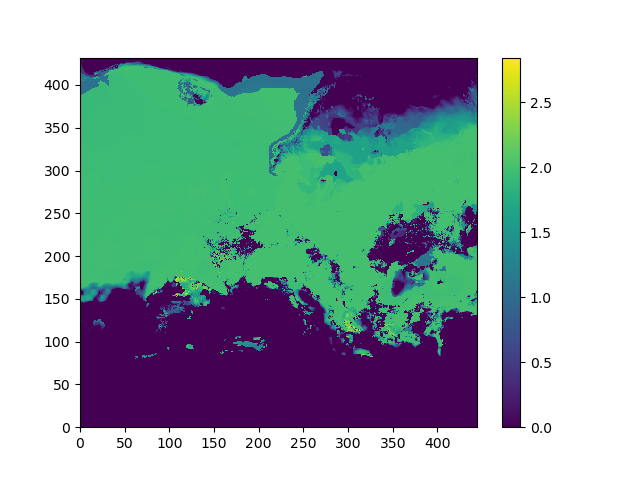

In [18]:
# data.tlai.max()
# data.pfts1d_ixy
# data.pfts1d_jxy

res = np.zeros([444,432])
np.add.at(res,(data.pfts1d_ixy.values.astype(int)-1,data.pfts1d_jxy.values.astype(int)-1),data.tlai.values)

%matplotlib widget
plt.figure()
plt.pcolormesh(res.T)
plt.colorbar()

In [13]:
data.pfts1d_ixy.values

array([  1.,   2.,   3., ..., 442., 443., 444.])

# Next steps

Run the main_DA.py script with all parameters enables (Ks, poros, slope etc.) to generate their .sa files

copy these .sa files to the template directory